# Practical Examples of Antibody Langauge Models

In the previous worksheet, we learned how to use antibody language models to encode sequences and fill in missing residues. We shall now use AbLang <sup>1</sup>, AntiBERTy <sup>2</sup> and IgLM <sup>3</sup> to explore the capabilities of antibody language models and how these prinicples can be applied.
In the following exercise, we shall learn:
- How to model antibody sequences using AntiBERTy
- How to generate sequence diversity using IgLM
- How to use encodings for machine learning to classify antibodies
- How to use antibody language models to predict physiochemical properties of antibodies

### References  
1. Olsen TH, Moal IH, Deane CM. AbLang: an antibody language model for completing antibody sequences. Bioinforma Adv. 2022;2(1):vbac046. doi:10.1093/bioadv/vbac046

2. Ruffolo JA, Chu L-S, Mahajan SP, Gray JJ. Fast, accurate antibody structure prediction from deep learning on massive set of natural antibodies. Nat Commun. 2023;14(1):2389. doi:10.1038/s41467-023-38063-x

3. Shuai RW, Ruffolo JA, Gray JJ. Generative language modeling for antibody design. bioRxiv. Published online January 1, 2022:2021.12.13.472419. doi:10.1101/2021.12.13.472419


In [4]:
##Imports##
import os
from urllib import request
from time import sleep

##Models##
import ablang
from antiberty import AntiBERTyRunner
from iglm import IgLM
from igfold import IgFoldRunner

##Machine Learning Models##
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

from Bio import PDB
import numpy as np

import numpy as np
from pandas import read_csv

##Initialize models##
heavy_ablang = ablang.pretrained("heavy")
heavy_ablang.freeze()
antiberty = AntiBERTyRunner()
igfold = IgFoldRunner()
iglm = IgLM()



    The code, data, and weights for this work are made available for non-commercial use 
    (including at commercial entities) under the terms of the JHU Academic Software License 
    Agreement. For commercial inquiries, please contact awichma2[at]jhu.edu.
    License: https://github.com/Graylab/IgFold/blob/main/LICENSE.md
    
Loading 4 IgFold models...
Using device: cuda:0
Loading /home/james/miniconda3/envs/L2D/lib/python3.11/site-packages/igfold/trained_models/IgFold/igfold_1.ckpt...
Loading /home/james/miniconda3/envs/L2D/lib/python3.11/site-packages/igfold/trained_models/IgFold/igfold_2.ckpt...
Loading /home/james/miniconda3/envs/L2D/lib/python3.11/site-packages/igfold/trained_models/IgFold/igfold_3.ckpt...
Loading /home/james/miniconda3/envs/L2D/lib/python3.11/site-packages/igfold/trained_models/IgFold/igfold_5.ckpt...
Successfully loaded 4 IgFold models.
Loaded AntiBERTy model.


In [5]:

###Functions###
def model_structure(antibody_identifier,heavy_chain,light_chain):
    ##Model antibody structure in AbYmod##
    antibody_identifier_name = antibody_identifier.replace("\/", "\|" )
    url          = "http://abymod.abysis.org/"\
                   "abymod_service.cgi"
    build_url    = url + "?" + "light=" + light_chain + "&heavy=" + heavy_chain
    #print(build_url)
    UID          = request.urlopen(build_url).read() #Enter model to abYmod and get UID
    UID          = str(UID, encoding='utf-8')
    retrieve_url = url + "?" + "pdb=" + UID
    metadata_url = url + "?" + "json=" + UID
    log_url      = url + "?" + "log=" + UID
    output          = open(antibody_identifier_name + ".pdb", 'w+') #Write pbd to file
    output_metadata = open(antibody_identifier_name + ".txt", "w+") #write metadata to separate file
    retrieve_model  = request.urlopen(retrieve_url).read() #retreive pbd
    retrieve_model  = str(retrieve_model, encoding='utf-8')
    retrieve_log    = request.urlopen(log_url).read()
    retrieve_log    = str(retrieve_log, encoding='utf-8')
    while retrieve_model == "0":
        if retrieve_log != "1":
            print("constructing model of ", antibody_identifier, " ...")
            retrieve_model  = request.urlopen(retrieve_url).read() #retreive pbd
            retrieve_model  = str(retrieve_model, encoding='utf-8')
            sleep(10)
            if retrieve_model == "1":
                print("model of ", light_chain_identifier, " could not be constructed")
                break
            if retrieve_model != "0" and retrieve_model != "1":
                print("model complete")
                output            = open(antibody_identifier_name + ".pdb", 'w+') #Write pbd to file
                output_metadata   = open(antibody_identifier_name + ".txt", "w+") #write metadata to separate file
                output.write(retrieve_model)
                retrieve_metadata = request.urlopen(metadata_url).read()
                retrieve_metadata = str(retrieve_metadata, encoding='utf-8')
                output_metadata.write(retrieve_metadata)
                output.close()
                output_metadata.close()
                break

        else:
            print("model of ", antibody_identifier, " could not be constructed")

def linear_regression_model(X,y):
    #Fit linear model to data#
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    new_model = LinearRegression()
    new_model.fit(X, y)
    return(r2,y_test,y_pred,mse)

def keep_selected_columns(input_array, selected_columns):
        # Select only the desired columns

    selected_columns = np.array(selected_columns)
    if not np.all((selected_columns >= 0) & (selected_columns < input_array.shape[1])):
        raise ValueError("Invalid column indexes in selected_columns.")
    output_array = input_array[:, selected_columns]
    return output_array

def calculate_rmsd(file1, file2):
    ##Calculate RMSD between two pdb files##
    # Load structures from PDB files
    parser = PDB.PDBParser(QUIET=True)
    structure1 = parser.get_structure('structure1', file1)
    structure2 = parser.get_structure('structure2', file2)
    coords1 = []
    coords2 = []
    for model1, model2 in zip(structure1, structure2):
        for chain1, chain2 in zip(model1, model2):
            for residue1, residue2 in zip(chain1, chain2):
                try:
                    atom1 = residue1['CA']
                    atom2 = residue2['CA']
                    coords1.append(atom1.get_coord())
                    coords2.append(atom2.get_coord())
                except KeyError:
                    continue
    coords1 = np.array(coords1)
    coords2 = np.array(coords2)
    # Calculate RMSD
    rmsd = np.sqrt(np.mean(np.sum((coords1 - coords2) ** 2, axis=1)))

    return rmsd


## Modelling Antibodies using Language Model Encodings

Below we will use igfold to model the example antibody sequence. This approach uses AntiBERTy to encode the antibodies to then model the structure using Rosetta. This is a very powerful approach as it allows us to model the structure of antibodies without the need for experimental data. This is particularly useful for antibodies that are difficult to express or purify.
However it is necessary to have an experimental structure to compare how sucessfulthe modelling has been. We will use the RMSD to compare the modelled structure to the experimental structure. The lower the RMSD, the more accurate the modelled structure is.
We will compare the igfold approach to AbYmod, which is based on more established homology modelling for antibodies. 


In [6]:

sequences = {
    "H": "QLQESGPSLVKPSQTLSLTCSVTGDSVTSDYWSWIRKFPGNKLEYMGYISYSGSTYYHPSLKSRISITRDTSKNQYYLQLTTEDTATYYCASWGGDVWGAGTTVTVSS",
    "L": "DIVLTQSPATLSVTPGDSVSLSCRASQSISNNLHWYQQKSHESPRLLIKYASQSISGIPSRFSGSGSGTDFTLSINSVETEDFGMYFCQQSNSWPYTFGGGTKLEIKRAV"
}
pdb_file = 'Data/1DQM_1.pdb'
pred_pdb = "my_antibody.pdb"

##IgFold###
IgFold_Model = igfold.fold(
   sequences=sequences, # Antibody sequences
   pdb_file = pred_pdb,
    do_refine=False, # Refine the antibody structure with PyRosetta
    do_renum=False, # Renumber predicted antibody structure (Chothia)
)



Completed folding in 6.54 seconds.


In [7]:
###AbYmod###
abYmod_Model = model_structure("Seq1", sequences["H"], sequences["L"])


constructing model of  Seq1  ...
constructing model of  Seq1  ...
constructing model of  Seq1  ...
constructing model of  Seq1  ...
constructing model of  Seq1  ...
constructing model of  Seq1  ...
model complete


In [8]:
# Compare IgFold Models:
pdb_file1 = pdb_file
pdb_file2 = 'my_antibody.pdb'
result_rmsd = calculate_rmsd(pdb_file1, pdb_file2)
print("RMSD:", result_rmsd)

# Compare abYmod Models
pdb_file1 = pdb_file
pdb_file2 = 'Seq1.pdb'
result_rmsd = calculate_rmsd(pdb_file1, pdb_file2)
print("RMSD:", result_rmsd)

RMSD: 89.49405
RMSD: 50.04961



We can see that the igfold approach has been more sucessful than abYmod.
- Why do you think this is? Hint: Think of where the antibody has come from
- What if we were to model a different antibody from a more recent PDB entry?


## Using Encodings of Antibody Language Models to Classify Sequences

Now we will look at how antibody language models can be used to classify sequences with simple machine learning algorithms. For this example we will classify Kappa and Lambda antibodies from our encoded dataset.


In [9]:
##Load Datasets##

X = np.load('/home/james/L2D_material/Data/OAS_1000_Human_seq.faa.npy',allow_pickle=True)##AntiBERTy
y = read_csv('/home/james/L2D_material/Data/Kappa_1_Lambda_0_Classes.txt',header=0)
y = np.asarray(y['Class'].values)

classifiers = {
   'Random Forest Classifier': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
   'Decision Tree': DecisionTreeClassifier(max_depth=5),
   'ADABoost':AdaBoostClassifier(),
   'Support Vector Machine Classifier':SVC(kernel="linear", C=0.025)
}


In [10]:

scores = []

for i in classifiers:
   clf_1 = classifiers.get(i)
   print(i)
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   clf_1.fit(X_train,y_train)
   y_predict1 = clf_1.predict(X_test)
   scoring = matthews_corrcoef(y_test, y_predict1)
   scores.append(scoring)
  

Random Forest Classifier
Decision Tree
ADABoost
Support Vector Machine Classifier


[0.9692123940380459, 1.0, 1.0, 1.0]


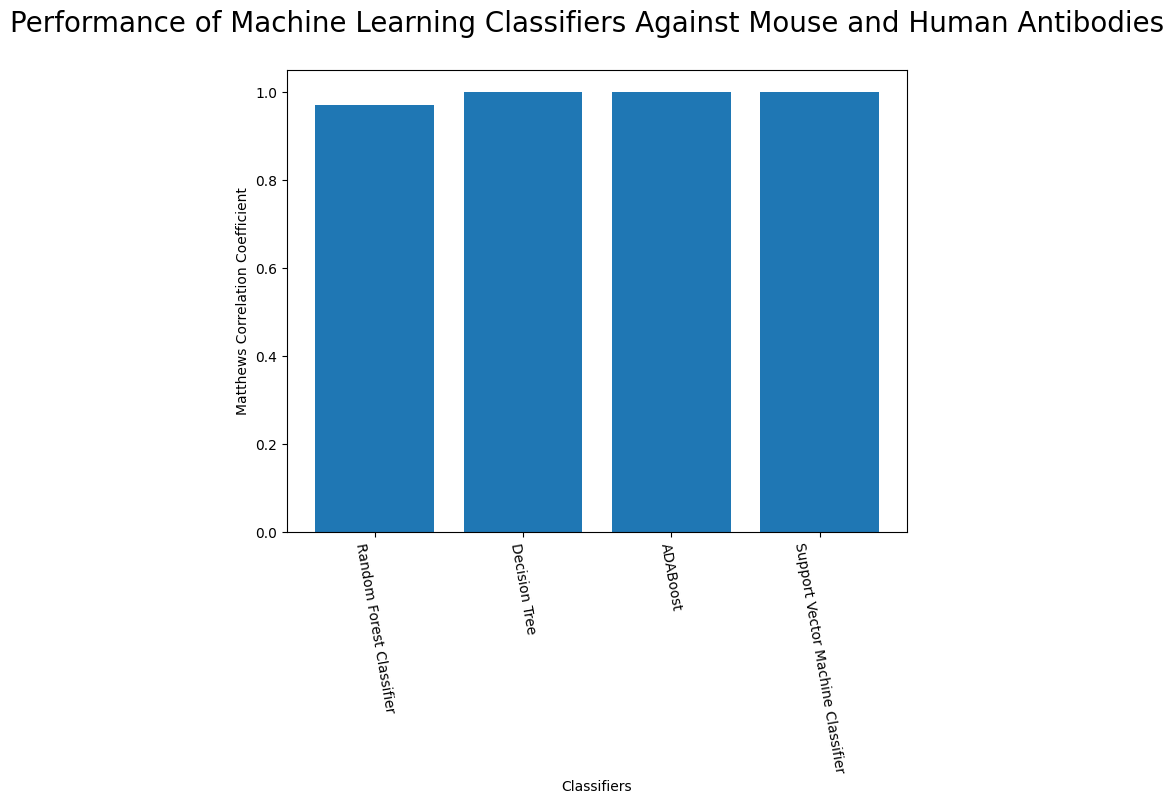

In [11]:
print(scores)   
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Kappa or Lambda antibodies', fontsize=20)
bins = np.arange(len(classifiers))
ax.bar(np.arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80)
plt.show()



Questions:
- Which classifier performs best? Why do you think this is?
- If all classifiers are performing well, why do you think this is? 
- Could this be potentially overfitting? How can we check this?



In [12]:
##Load Datasets##

X = np.load('/home/james/L2D_material/Data/OAS_1000_Human_seq.faa.npy',allow_pickle=True)##AntiBERTy
y = read_csv('/home/james/L2D_material/Data/OAS_1000_Human_seq.faa.npypredicted_Features.csv',header=0)
y = list(y['Developability Score'].values)
y = np.asarray([1 if value != 0 else 0 for value in y])


classifiers = {
   'Random Forest Classifier': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
   'Decision Tree': DecisionTreeClassifier(max_depth=5),
   'Support Vector Machine Classifier':SVC(kernel="linear", C=0.025)
}

In [13]:
scores = []

for i in classifiers:
   clf_1 = classifiers.get(i)
   print(i)
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   clf_1.fit(X_train,y_train)
   y_predict1 = clf_1.predict(X_test)
   scoring = matthews_corrcoef(y_test, y_predict1)
   scores.append(scoring)
     

Random Forest Classifier
Decision Tree
Support Vector Machine Classifier


[0.28141058827257937, 0.32824397594488725, 0.5450228058050522]


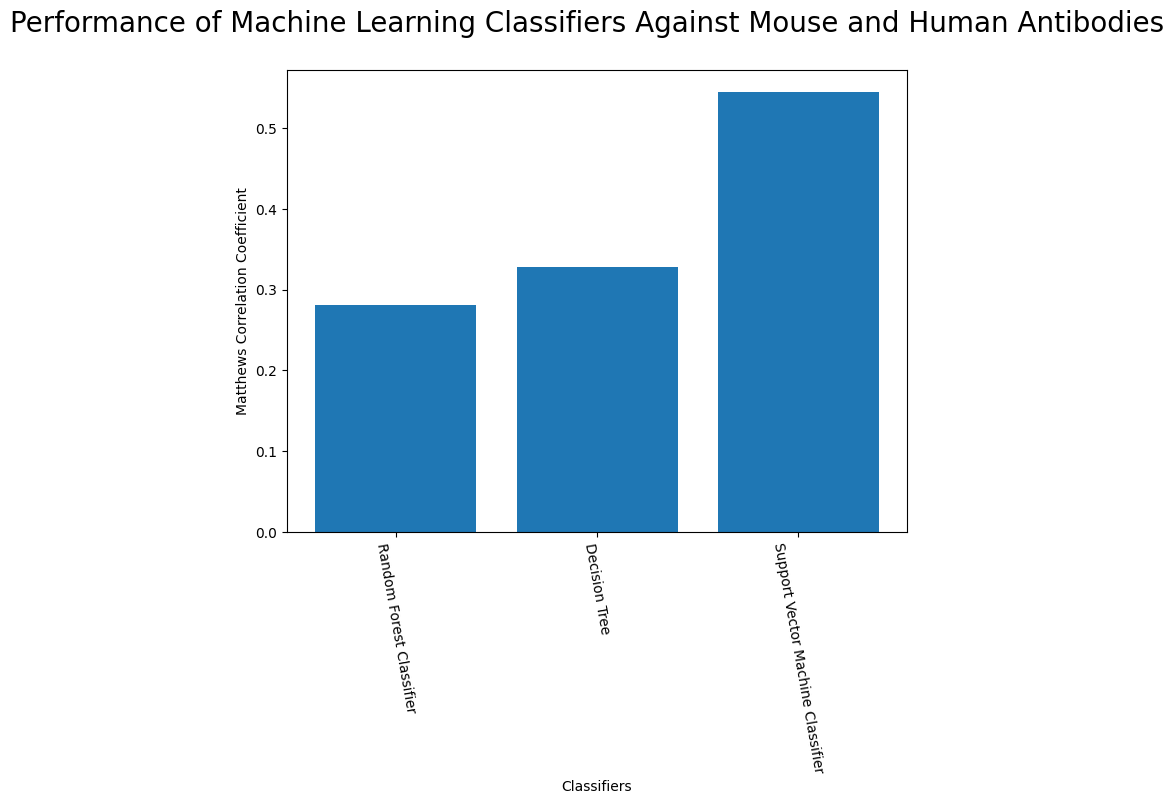

In [14]:
print(scores)   
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Antibodies with Developability Traits', fontsize=20)
bins = np.arange(len(classifiers))
ax.bar(np.arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80)
plt.show()



Question:
- Which classifier performs best? Why do you think this is?
- Why do these classifiers perform worse than the previous classifiers?

Task:
- Use additional machine learning classifiers by adding them to the classifiers dictionary. A list of machine learning classifiers can be found here: https://scikit-learn.org/stable/supervised_learning.html
- Can you think of a way to improve the performance of the classifiers using the classifiers?
- Can you think of a way to improve the performance of the classifiers using the encodings?




## Using Antibody Language Models to Predict Physiochemical Properties for Developability Assessment
This task is a more exploratory look at how antibody language models can be used to predict physiochemical properties of antibodies. We provide some experimental data of antibody melting curves and their antibodies. We will use the language models encodings to train a model to predict the melting temperature of naive antibodies.



In [15]:
X = np.load('/home/james/L2D_material/Data/OAS_1000_Human_seq.faa.npy',allow_pickle=True)##AntiBERTy
y = read_csv('/home/james/L2D_material/Data/OAS_1000_Human_seq.faa.npypredicted_Features.csv',header=0)
y = np.asarray(y['Tm(Negated)'].values)

###Train Linear model on all encodings###
print(X.shape)
all_data = linear_regression_model(X,y)
print(all_data[0],all_data[3])

(1000, 192768)
0.8256001296687673 6.50873749012633


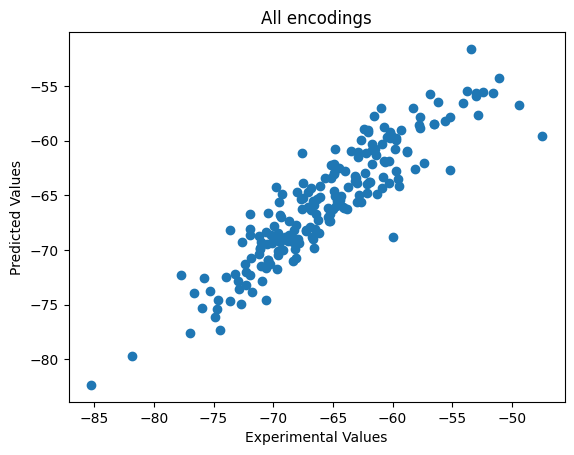

In [17]:

# Plot on the first subplot
plt.scatter(all_data[1], all_data[2])
plt.xlabel("Experimental Values")
plt.ylabel("Predicted Values")
plt.title('All encodings')

plt.show()


Can the encodings be used to predict the melting temperature of antibodies?
What do you think the p value correlated encodings are?
Can we adjust the significance threshold to lower than 0.05 to improve the performance of the model?
Does the model work for other physiochemical properties given in the dataset?





## End of Chapter Exercise

Now you have covered some of the basics of how protein language models work, use these new skills to complete the following task:
VH = 'EVHLVESGGGLVQPGGSLRLSCVASGFTFSTYWMSWVRQAPGKGLEWVANIKQDGSEKYYVDSVKGRFTISRDNAKRSLCLQMNSLGDEDTAVYYCAREYVNGYSGSRFLDHWGQGTLVTVSS'
VL = 'SYVLTQPPSVSVAPGQTARITCGGNNIGSKSVYWYQQNPGQAPVLVVFDDTARPSGIPERFSGSNSGNTATLTISRVEAGDEADYYCQVWDSSSDHVIFGGGTKLTVL'

Complete the following tasks
- Write a function that will substitute each amino acid in the heavy chain CDRH3 loop with every other possible amino acid
- Use your previously trained linear model to detect if there would be significant changes to the antibody stability for each mutation
- Find what mutations are the most stabilising, and which mutations are the most destabilising



